# MAST30034_Applied Data Science_Project1

## Import Libraries

In [22]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
from geodatasets import get_path
import pandas as pd
import geopandas as gpd
from pyspark.sql.functions import date_format, hour, dayofweek
import seaborn as sns
from scipy.stats import chi2_contingency
from pyspark.sql.functions import count as spark_count
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler

In [23]:
# Create a spark session
spark = (
SparkSession.builder.appName("ADS project 1")
.config("spark.sql.repl.eagerEval.enabled", True)
.config("spark.driver.memory","6G")
.config("spark.executor.memory","6G")
.config("spark.sql.parquet.cacheMetadata", "true")
.config("spark.sql.session.timeZone", "Etc/UTC")
.getOrCreate()
)

## Read Data

In [24]:
taxi_data = spark.read.parquet('../data/data_after_preprocessing/taxi')
citybike_data = spark.read.parquet('../data/data_after_preprocessing/citybike')
weather_data = spark.read.parquet('../data/data_after_preprocessing/weather')

In [25]:
taxi_zones = gpd.read_file("../data/raw/NYCTLC_data/taxi_zone_shipfile/taxi_zones.shp")

In [26]:
taxi_data.columns

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'duration']

In [27]:
citybike_data.columns

['ride_id',
 'rideable_type',
 'started_at',
 'ended_at',
 'start_station_name',
 'start_station_id',
 'end_station_name',
 'end_station_id',
 'start_lat',
 'start_lng',
 'end_lat',
 'end_lng',
 'member_casual',
 'duration']

In [28]:
weather_data.columns

['name',
 'datetime',
 'temp',
 'feelslike',
 'dew',
 'humidity',
 'precip',
 'precipprob',
 'preciptype',
 'snow',
 'snowdepth',
 'windgust',
 'windspeed',
 'winddir',
 'sealevelpressure',
 'cloudcover',
 'visibility',
 'solarradiation',
 'solarenergy',
 'uvindex',
 'severerisk',
 'conditions',
 'icon',
 'stations']

## Divide the data into the first nine months and the second two months

In [29]:
# the function use to spit the data
def split_data_by_date(data, date_column):
    start_date_1 = "2023-01-31"
    end_date_1 = "2023-11-01"
    start_date_2 = "2023-10-31"
    end_date_2 = "2024-01-01"
    split_1 = data.filter((F.col(date_column) > start_date_1) & (F.col(date_column) < end_date_1))
    split_2 = data.filter((F.col(date_column) > start_date_2) & (F.col(date_column) <= end_date_2))
    return split_1, split_2

In [30]:
taxi_data_9,taxi_data_2 = split_data_by_date(taxi_data, 'tpep_pickup_datetime')

In [31]:
citybike_data_9,citybike_data_2 = split_data_by_date(citybike_data, 'started_at')

In [32]:
weather_data_9,weather_data_2 = split_data_by_date(weather_data, 'datetime')

## Research on taxi demand of the map

Draw the map for New York

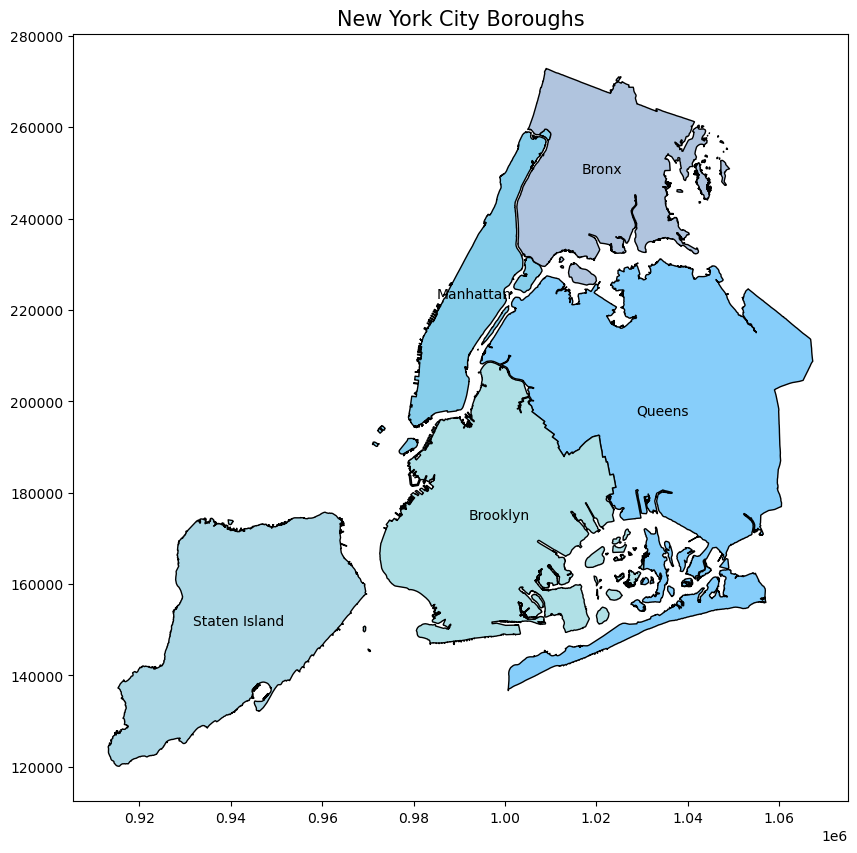

In [33]:
path_to_file = get_path('nybb')
nyc_map = gpd.read_file(path_to_file)
colors = ['#add8e6', '#87cefa', '#b0e0e6', '#87ceeb', '#b0c4de']
fig, ax = plt.subplots(figsize=(10, 10))
nyc_map.plot(ax=ax, color=colors, edgecolor='black')
nyc_map.apply(lambda x: ax.annotate(text=x['BoroName'], xy=x.geometry.centroid.coords[0], ha='center', color='black'), axis=1)
plt.title("New York City Boroughs", fontsize=15)
plt.show()

Draw the taxizone shipfile for New York

<Axes: >

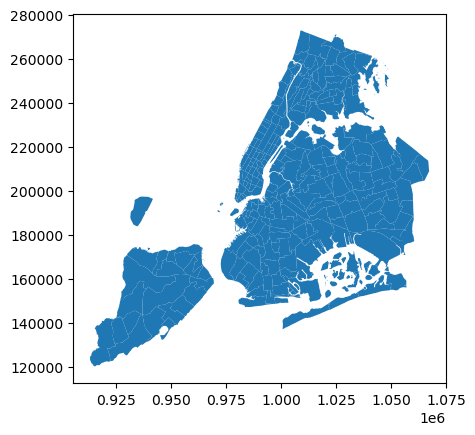

In [34]:
taxi_zones.plot()

Taxi boarding counted by zone

<Figure size 1200x800 with 0 Axes>

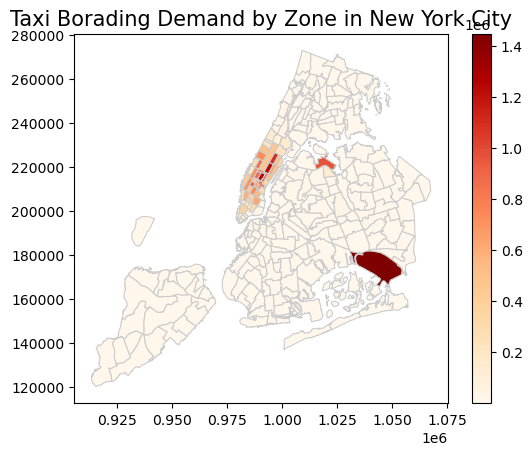

In [35]:
# Count the number of passengers in each zone of NewYork
demand_data_PUL = taxi_data_9.groupBy("PULocationID").count()
demand_data_PUL = demand_data_PUL.withColumnRenamed("count", "demand")
pandas_demand_data_PUL = demand_data_PUL.toPandas()

# Combine the zone data with the taxi demand data
taxi_zones_merge_PUL = taxi_zones.merge(pandas_demand_data_PUL, how='left', left_on='LocationID', right_on='PULocationID')

# Drawing an image
plt.figure(figsize=(12, 8))
taxi_zones_merge_PUL.plot(column='demand', cmap='OrRd', linewidth=0.8, edgecolor='0.8', legend=True)
plt.title('Taxi Borading Demand by Zone in New York City',fontsize=15)
plt.show()

In [36]:
# Write the top 10 zone
top_10_zones_PUL = taxi_zones_merge_PUL.nlargest(10, 'demand')[['zone', 'demand']]
top_10_zones_PUL

,zone,demand
131,JFK Airport,1447185.0
160,Midtown Center,1253928.0
236,Upper East Side South,1246085.0
235,Upper East Side North,1094698.0
137,LaGuardia Airport,961628.0
161,Midtown East,960874.0
185,Penn Station/Madison Sq West,928246.0
229,Times Sq/Theatre District,895858.0
141,Lincoln Square East,870117.0
169,Murray Hill,802127.0


Taxi drop-off zone count

<Figure size 1200x800 with 0 Axes>

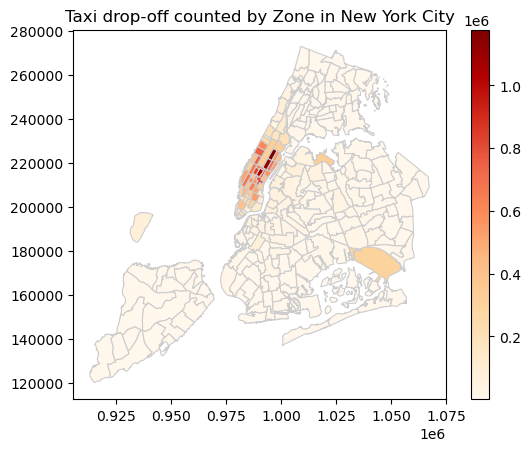

In [37]:
# Count the number of passengers in each zone of NewYork
demand_data_DOL = taxi_data_9.groupBy("DOLocationID").count()
demand_data_DOL = demand_data_DOL.withColumnRenamed("count", "demand")
pandas_demand_data_DOL = demand_data_DOL.toPandas()

# Combine the zone data with the taxi drop-off counted data
taxi_zones_merge_DOL = taxi_zones.merge(pandas_demand_data_DOL, how='left', left_on='LocationID', right_on='DOLocationID')

# Drawing an image
plt.figure(figsize=(12, 8))
taxi_zones_merge_DOL.plot(column='demand', cmap='OrRd', linewidth=0.8, edgecolor='0.8', legend=True)
plt.title('Taxi drop-off counted by Zone in New York City')
plt.show()

In [38]:
# Write the top 10 zone
top_10_zones_DOL = taxi_zones_merge_DOL.nlargest(10, 'demand')[['zone', 'demand']]
top_10_zones_DOL

,zone,demand
235,Upper East Side North,1177657.0
236,Upper East Side South,1120353.0
160,Midtown Center,1041861.0
229,Times Sq/Theatre District,830793.0
169,Murray Hill,798397.0
161,Midtown East,760205.0
141,Lincoln Square East,748274.0
238,Upper West Side South,748130.0
140,Lenox Hill West,704563.0
67,East Chelsea,674912.0


## The Top 10 start station of citi Bike

In [39]:
# Count the stations with the highest number of bike 
def plot_top_stations(citybike_data, feature_name):
    start_stations_count = citybike_data.groupBy(feature_name).count().orderBy(F.desc("count")).limit(10)
    start_stations_count = start_stations_count.toPandas()
    # Draw a bar chart
    plt.figure(figsize=(20, 8))
    plt.bar(start_stations_count[feature_name], start_stations_count['count'], color='lightblue', width=0.6)
    for i in range(len(start_stations_count)):
        plt.text(i, start_stations_count['count'][i] + 100, f"{start_stations_count['count'][i]}",
                 ha='center', fontsize=15)
    plt.title(f"Top 10 {feature_name} in NewYork", fontsize=30)
    plt.xlabel("Station Name", fontsize=20)
    plt.ylabel("Count", fontsize=20)
    plt.xticks(rotation=20, ha="right", fontsize=15)
    plt.yticks(fontsize=15)
    plt.show()

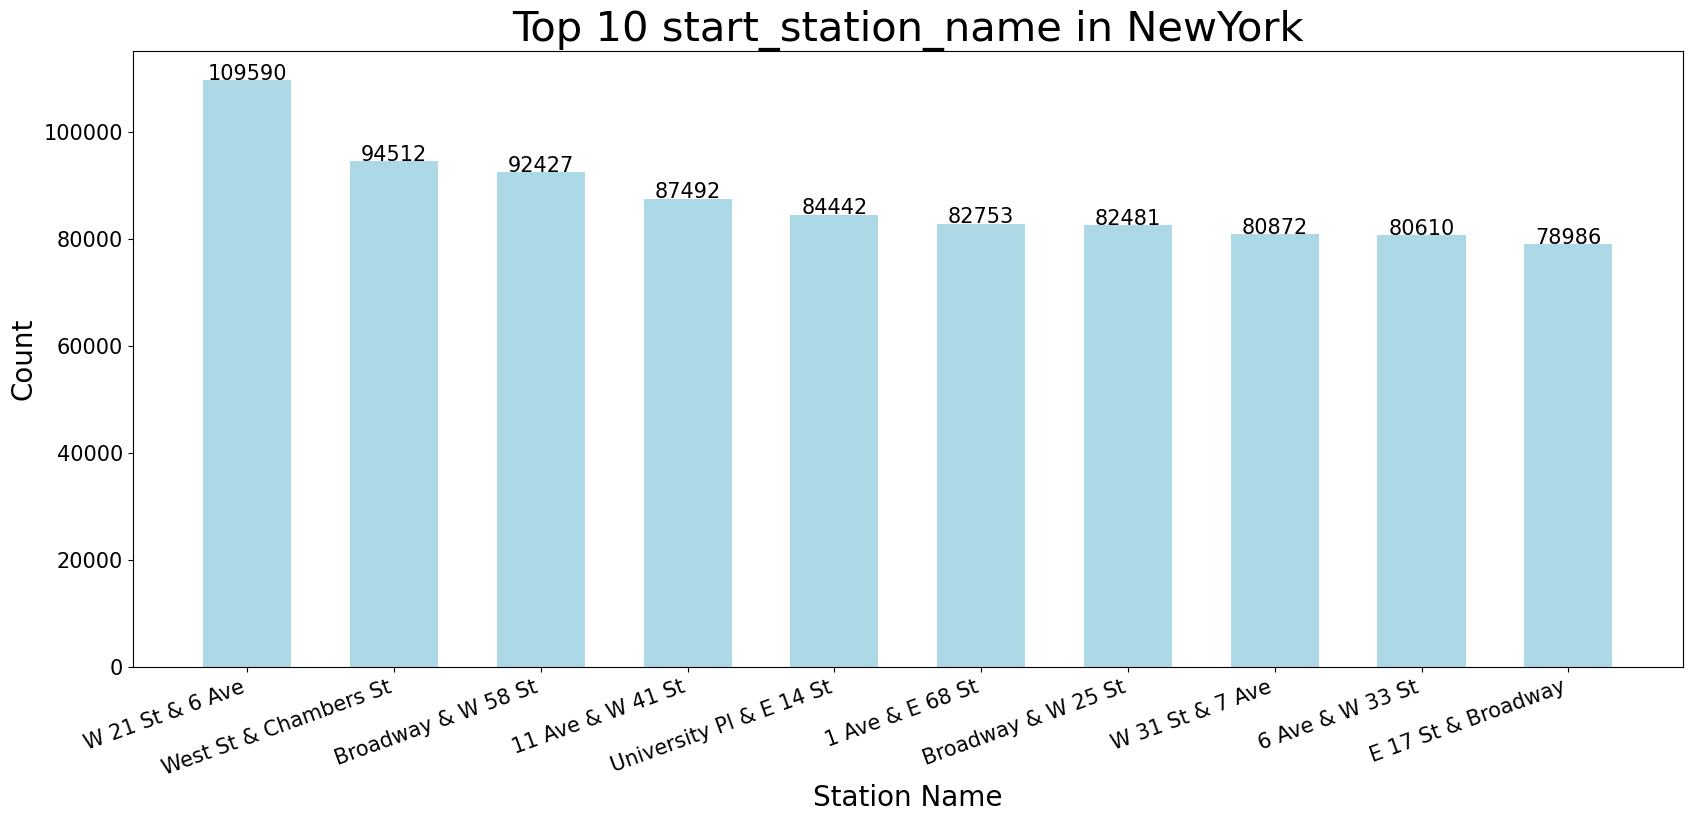

In [40]:
plot_top_stations(citybike_data_9, feature_name ='start_station_name')

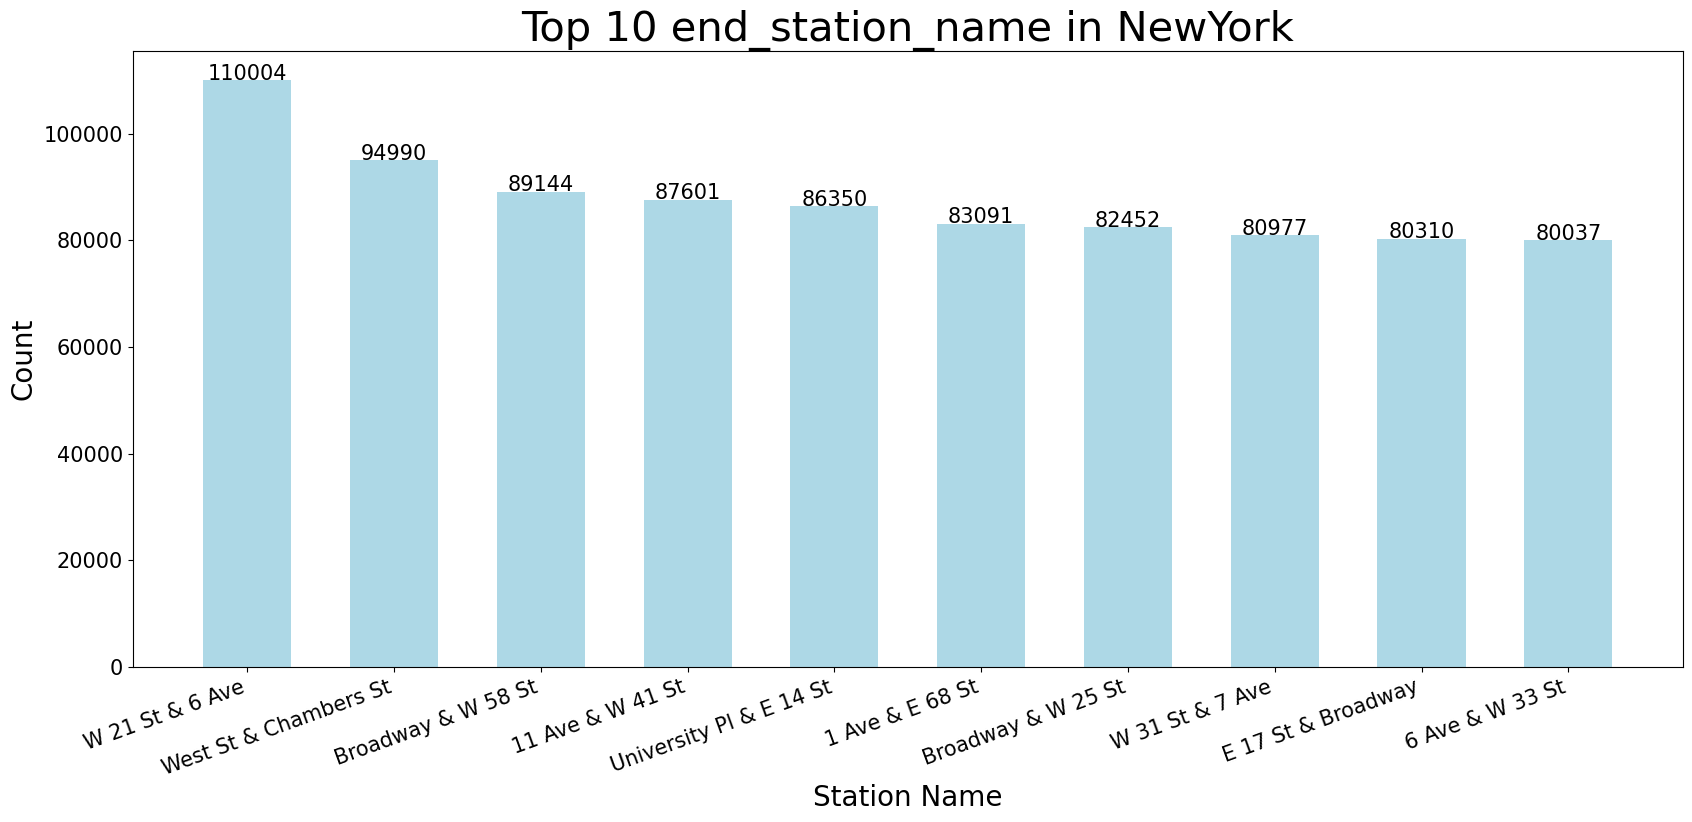

In [41]:
plot_top_stations(citybike_data_9, feature_name ='end_station_name')

## Time series segmentation

### Draw the plot for taxi/cityBike demand by day

In [42]:
# Separate the start time to date & hour
taxi_data_9 = taxi_data_9.withColumn("date", date_format(col("tpep_pickup_datetime"), "yyyy-MM-dd"))
citybike_data_9 = citybike_data_9.withColumn("date", date_format(col("started_at"), "yyyy-MM-dd"))
taxi_data_2 = taxi_data_2.withColumn("date", date_format(col("tpep_pickup_datetime"), "yyyy-MM-dd"))
citybike_data_2 = citybike_data_2.withColumn("date", date_format(col("started_at"), "yyyy-MM-dd"))

In [43]:
# Count by date
taxi_count_by_date_9 = taxi_data_9.groupBy("date").agg(count("*").alias("taxi_count")).orderBy("date").toPandas()
citybike_count_by_date_9 = citybike_data_9.groupBy("date").agg(count("*").alias("citybike_count")).orderBy("date").toPandas()
taxi_count_by_date_2 = taxi_data_2.groupBy("date").agg(count("*").alias("taxi_count")).orderBy("date").toPandas()
citybike_count_by_date_2 = citybike_data_2.groupBy("date").agg(count("*").alias("citybike_count")).orderBy("date").toPandas()

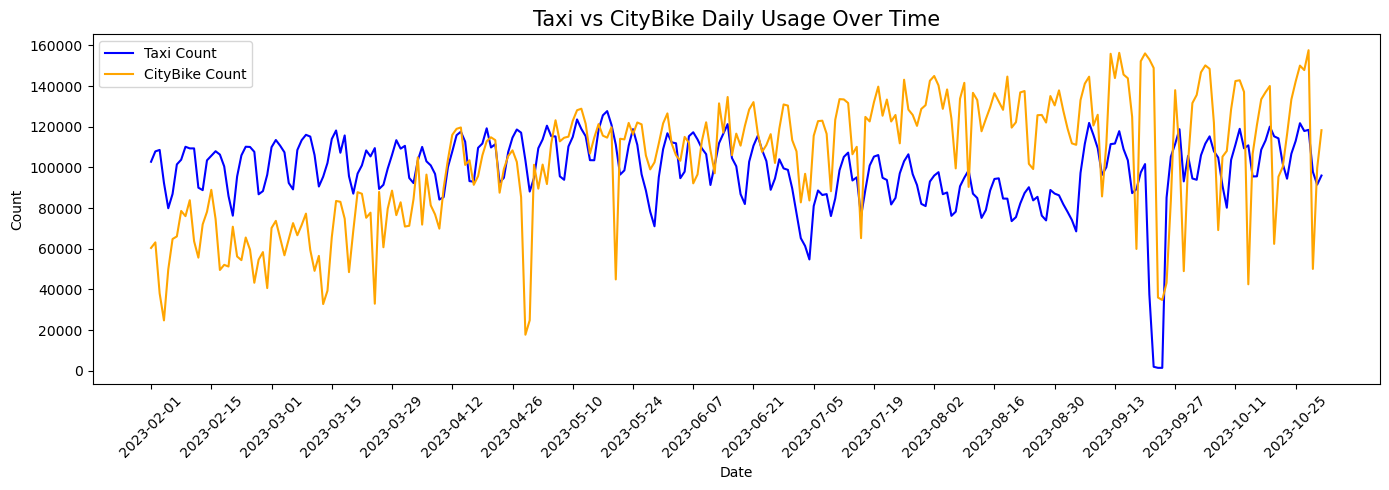

In [44]:
# Draw the time series for Taxi and CityBike data
plt.figure(figsize=(14, 5))
plt.plot(taxi_count_by_date_9["date"], taxi_count_by_date_9["taxi_count"], label="Taxi Count", color="blue")
plt.plot(citybike_count_by_date_9["date"], citybike_count_by_date_9["citybike_count"], label="CityBike Count", color="orange")
plt.xlabel("Date")
plt.ylabel("Count")
plt.title("Taxi vs CityBike Daily Usage Over Time",fontsize=15)
plt.legend()
dates = citybike_count_by_date_9["date"]
plt.xticks(ticks=range(0, len(dates), 14), labels=dates[::14], rotation=45)
plt.tight_layout()
plt.show()

### Draw the plot for taxi/cityBike demand by week

In [45]:
# Extract the hour and day of the week
taxi_data_9 = taxi_data_9.withColumn("hour", hour(col("tpep_pickup_datetime")))
taxi_data_9 = taxi_data_9.withColumn("day_of_week", dayofweek(col("tpep_pickup_datetime")))
citybike_data_9 = citybike_data_9.withColumn("hour", hour(col("started_at")))
citybike_data_9 = citybike_data_9.withColumn("day_of_week", dayofweek(col("started_at")))
taxi_data_2 = taxi_data_2.withColumn("hour", hour(col("tpep_pickup_datetime")))
taxi_data_2 = taxi_data_2.withColumn("day_of_week", dayofweek(col("tpep_pickup_datetime")))
citybike_data_2 = citybike_data_2.withColumn("hour", hour(col("started_at")))
citybike_data_2 = citybike_data_2.withColumn("day_of_week", dayofweek(col("started_at")))

In [46]:
# Count by date and hour
taxi_grouped_9 = taxi_data_9.groupBy("hour", "day_of_week").count().orderBy("hour", "day_of_week")
taxi_grouped_pd_9 = taxi_grouped_9.toPandas()
citybike_grouped_9 = citybike_data_9.groupBy("hour", "day_of_week").count().orderBy("hour", "day_of_week")
citybike_grouped_pd_9 = citybike_grouped_9.toPandas()

taxi_grouped_2 = taxi_data_2.groupBy("hour", "day_of_week").count().orderBy("hour", "day_of_week")
taxi_grouped_pd_2 = taxi_grouped_2.toPandas()
citybike_grouped_2 = citybike_data_2.groupBy("hour", "day_of_week").count().orderBy("hour", "day_of_week")
citybike_grouped_pd_2 = citybike_grouped_2.toPandas()

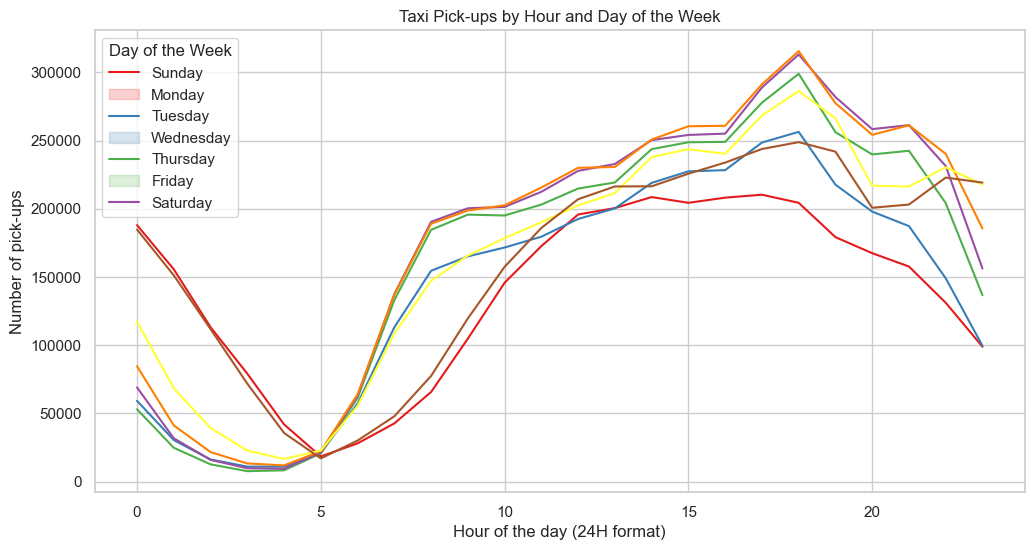

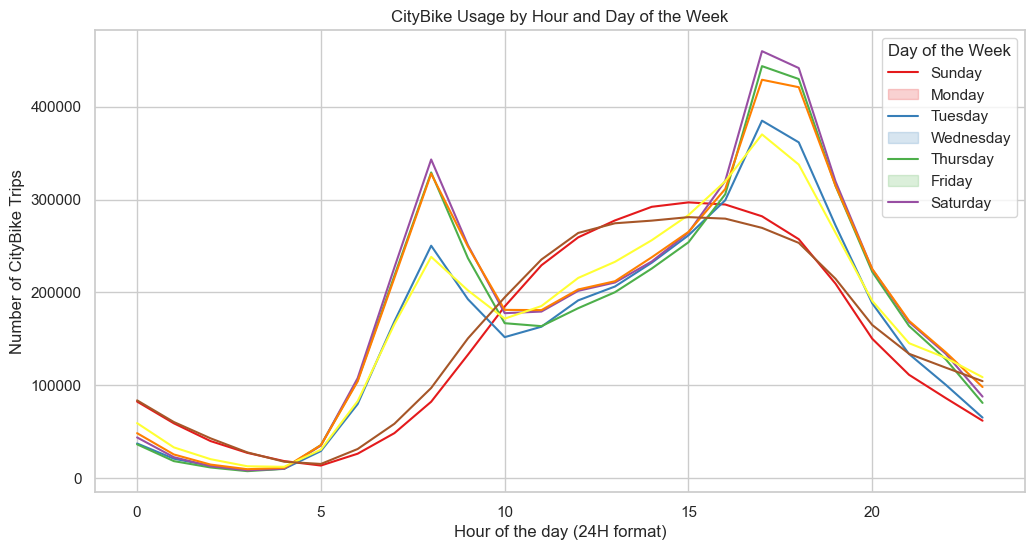

In [47]:
# Draw the plot
sns.set(style="whitegrid")

# Plot taxi usage
plt.figure(figsize=(12, 6))
sns.lineplot(x="hour", y="count", hue="day_of_week", data=taxi_grouped_pd_9, palette="Set1")
plt.title("Taxi Pick-ups by Hour and Day of the Week")
plt.xlabel("Hour of the day (24H format)")
plt.ylabel("Number of pick-ups")
plt.legend(title="Day of the Week", labels=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
plt.show()

# Plot cityBike usage
plt.figure(figsize=(12, 6))
sns.lineplot(x="hour", y="count", hue="day_of_week", data=citybike_grouped_pd_9, palette="Set1")
plt.title("CityBike Usage by Hour and Day of the Week")
plt.xlabel("Hour of the day (24H format)")
plt.ylabel("Number of CityBike Trips")
plt.legend(title="Day of the Week", labels=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
plt.show()


## The Distribution of categorial data

### Categorical Data of taxi_data

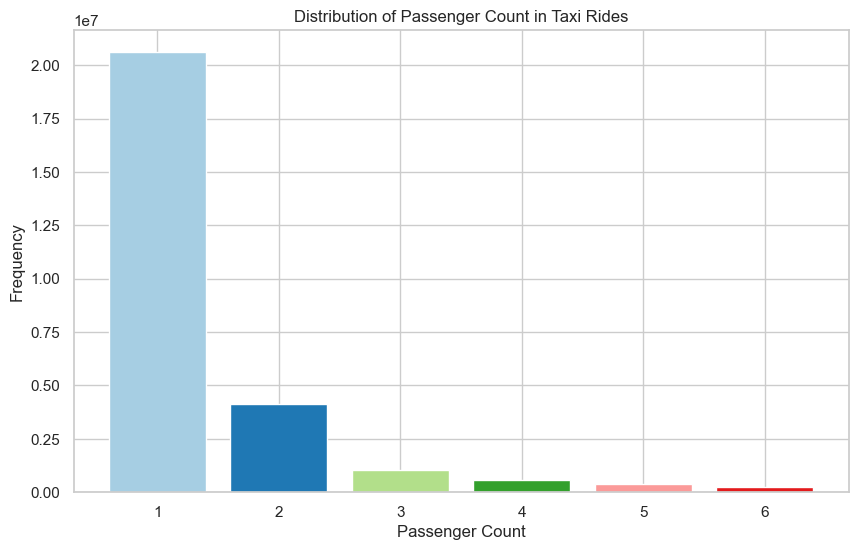

In [48]:
# Group by passenger_count and aggregate the counts
passenger_count = taxi_data_9.groupBy("passenger_count").agg(count("*").alias("count")).orderBy("passenger_count").toPandas()

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(passenger_count["passenger_count"], passenger_count["count"], color=plt.cm.Paired.colors)
plt.title("Distribution of Passenger Count in Taxi Rides")
plt.xlabel("Passenger Count")
plt.ylabel("Frequency")
plt.xticks(rotation=0)
plt.show()

### Categorical data of cityBike

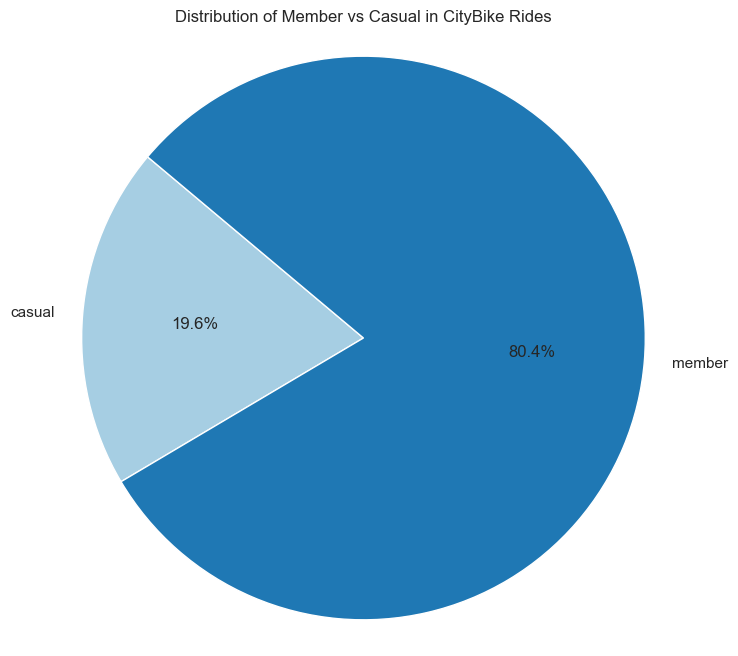

In [49]:
# Group by member_causual and aggregate the counts
member_casual_distribution = citybike_data_9.groupBy("member_casual").agg(count("*").alias("count")).orderBy("member_casual").toPandas()
# plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(member_casual_distribution["count"], labels=member_casual_distribution["member_casual"], autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title("Distribution of Member vs Casual in CityBike Rides")
plt.axis('equal') 
plt.show()

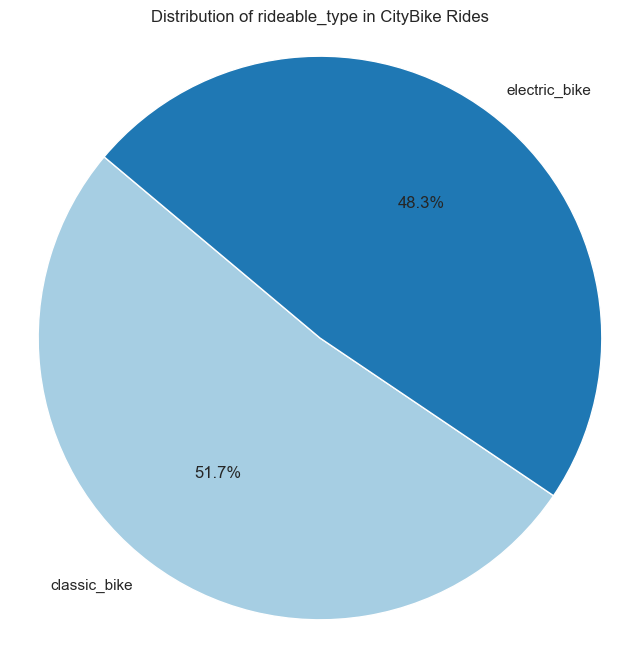

In [50]:
# Group by rideable_type and aggregate the counts
rideable_type_distribution = citybike_data_9.groupBy("rideable_type").agg(count("*").alias("count")).orderBy("rideable_type").toPandas()
plt.figure(figsize=(8, 8))
plt.pie(rideable_type_distribution["count"], labels=rideable_type_distribution["rideable_type"], autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title("Distribution of rideable_type in CityBike Rides")
plt.axis('equal') 
plt.show()

### Categorical data of weather

In [51]:
# The function use to plot the distribution of categorical data
def plot_categorical_distributions_grid(df, categorical_columns):
    categorical_df = df.select(categorical_columns).toPandas()
    num_cols = 3 
    num_rows = (len(categorical_columns) + num_cols - 1) // num_cols 
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 4))
    axes = axes.flatten()
    
    for i, column in enumerate(categorical_df.columns):
        order = df.groupBy(column).agg(count("*").alias("count")).orderBy("count", ascending=False).select(column).rdd.flatMap(lambda x: x).collect()
        sns.countplot(x=column, data=categorical_df.dropna(), order=order, ax=axes[i], width= 1) 
        axes[i].set_title(f"Distribution of {column}",fontsize=15)
        axes[i].set_xlabel(column.capitalize())
        axes[i].set_ylabel('Frequency')
        axes[i].tick_params(axis='x', rotation=50)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout() 
    plt.show()

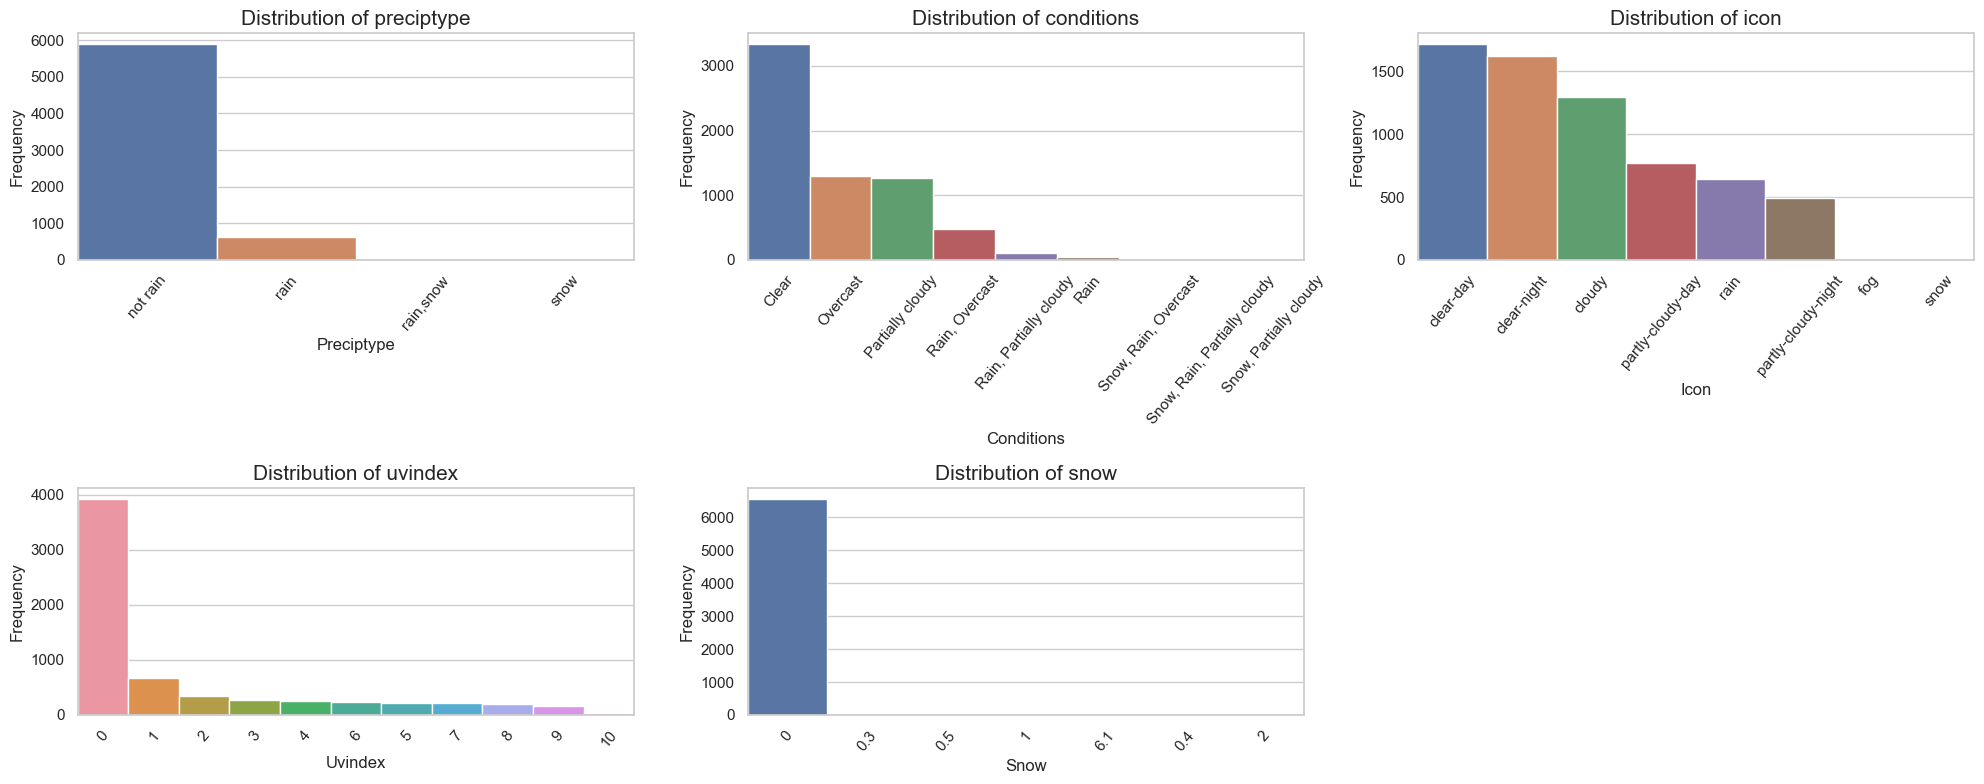

In [52]:
plot_categorical_distributions_grid(weather_data_9, ['preciptype','conditions','icon','uvindex','snow'])

## The Distribution of numerical data

In [53]:
# The function use to draw the distribution of numerical data
def plot_numerical_distributions_grid(df, numeric_columns):
    numeric_df = df.select(numeric_columns).toPandas()
    numeric_df = numeric_df.apply(pd.to_numeric, errors='coerce')
    num_cols = 5
    num_rows = -(-len(numeric_columns) // num_cols) 
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 16))
    axes = axes.flatten() 

    for i, column in enumerate(numeric_df.columns):
        sns.histplot(numeric_df[column].dropna(), kde=True, bins=30, ax=axes[i])
        axes[i].set_title(f'Distribution of {column}')
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Frequency')
    
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout() 
    plt.show()  


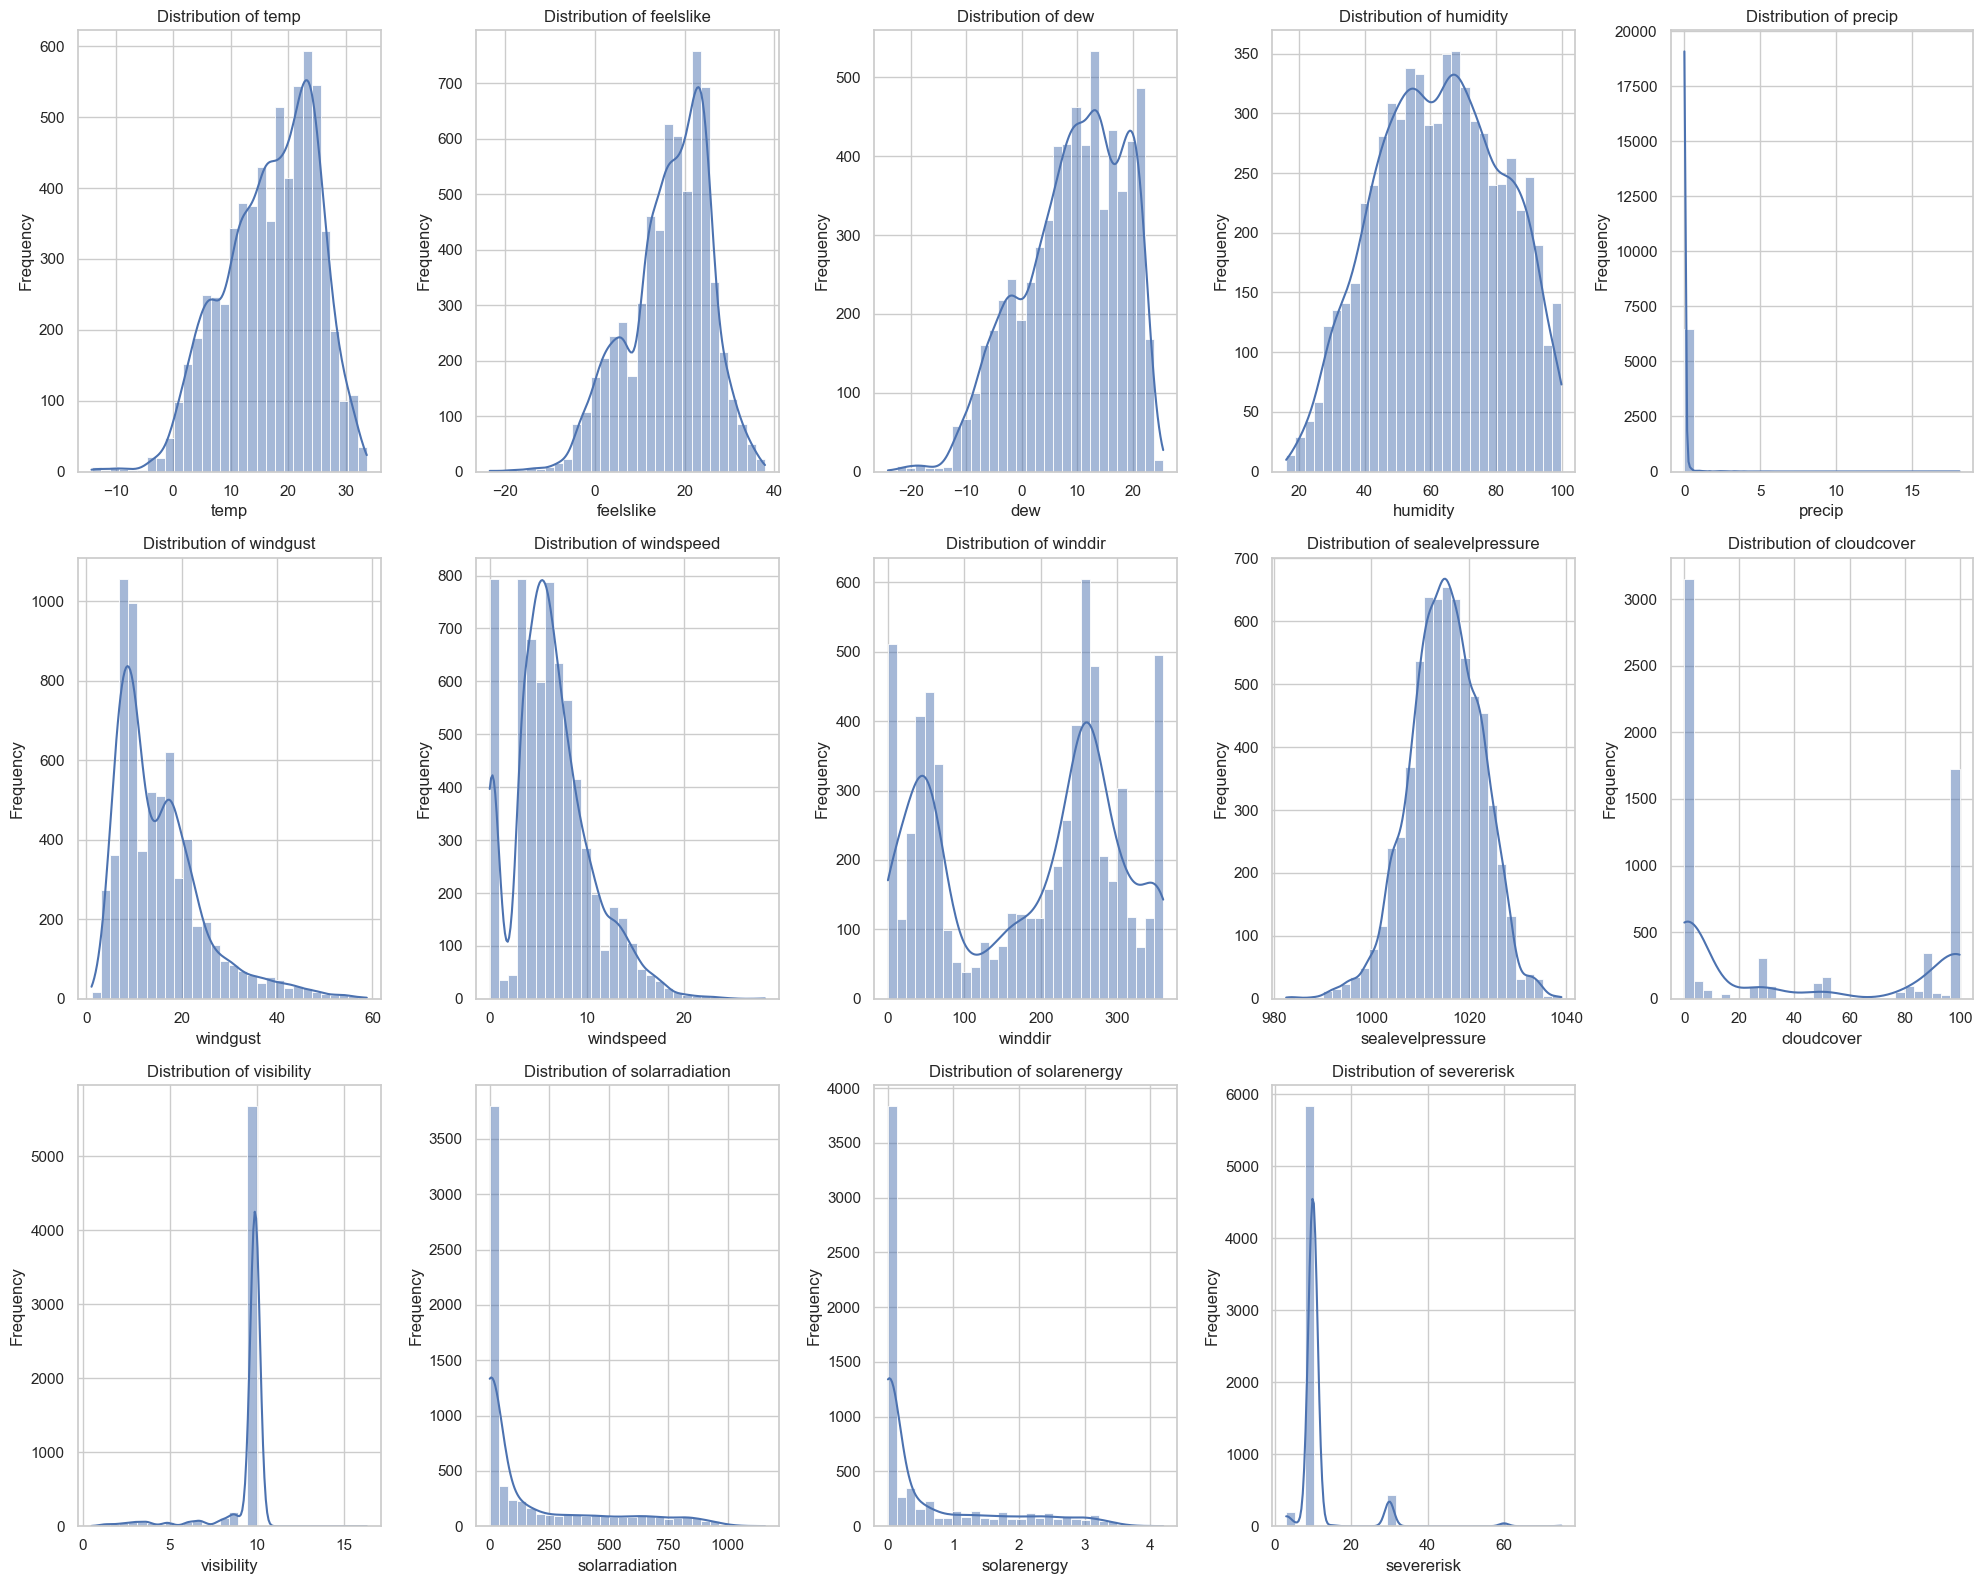

In [54]:
# The numerical Attribute need check the distribution
numeric_columns = ['temp', 'feelslike', 'dew', 'humidity', 'precip', 
            'windgust', 'windspeed', 'winddir', 
           'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 
           'solarenergy','severerisk']
plot_numerical_distributions_grid(weather_data_9, numeric_columns)

## Merge the weather data with taxi_data and cityBike date

In [55]:
# count data by date and hour
taxi_hourly_count_9 = taxi_data_9.groupBy("date", "hour").agg(count("*").alias("taxi_count"))
citybike_hourly_count_9 = citybike_data_9.groupBy("date", "hour").agg(count("*").alias("citybike_count"))

taxi_hourly_count_2 = taxi_data_2.groupBy("date", "hour").agg(count("*").alias("taxi_count"))
citybike_hourly_count_2 = citybike_data_2.groupBy("date", "hour").agg(count("*").alias("citybike_count"))

weather_data_9 = weather_data_9.withColumn("date", date_format(col("datetime"), "yyyy-MM-dd"))
weather_data_9 = weather_data_9.withColumn("hour", hour(col("datetime")))

weather_data_2 = weather_data_2.withColumn("date", date_format(col("datetime"), "yyyy-MM-dd"))
weather_data_2 = weather_data_2.withColumn("hour", hour(col("datetime")))
# combine the data of weather and citybike data,taxi_data
combined_taxi_weather_9 = taxi_hourly_count_9.join(weather_data_9, on=["date", "hour"], how="inner")
combined_citybike_weather_9 = citybike_hourly_count_9.join(weather_data_9, on=["date", "hour"], how="inner")

combined_taxi_weather_2 = taxi_hourly_count_2.join(weather_data_2, on=["date", "hour"], how="inner")
combined_citybike_weather_2 = citybike_hourly_count_2.join(weather_data_2, on=["date", "hour"], how="inner")

In [56]:
combined_taxi_weather_2 = combined_taxi_weather_2.drop('date','name','stations')
combined_taxi_weather_9 = combined_taxi_weather_9.drop('date','name','stations')

In [57]:
combined_citybike_weather_9 = combined_citybike_weather_9.drop('date','name','stations')
combined_citybike_weather_2 = combined_citybike_weather_2.drop('date','name','stations')

In [58]:
print(f"Number of rows: {combined_taxi_weather_2.count()}")
print(f"Number of columns: {len(combined_taxi_weather_2.columns)}")

Number of rows: 1489
Number of columns: 24


In [59]:
print(f"Number of rows: {combined_taxi_weather_9.count()}")
print(f"Number of columns: {len(combined_taxi_weather_9.columns)}")

Number of rows: 6551
Number of columns: 24


## Average demand of taxi/citybike on different coditions

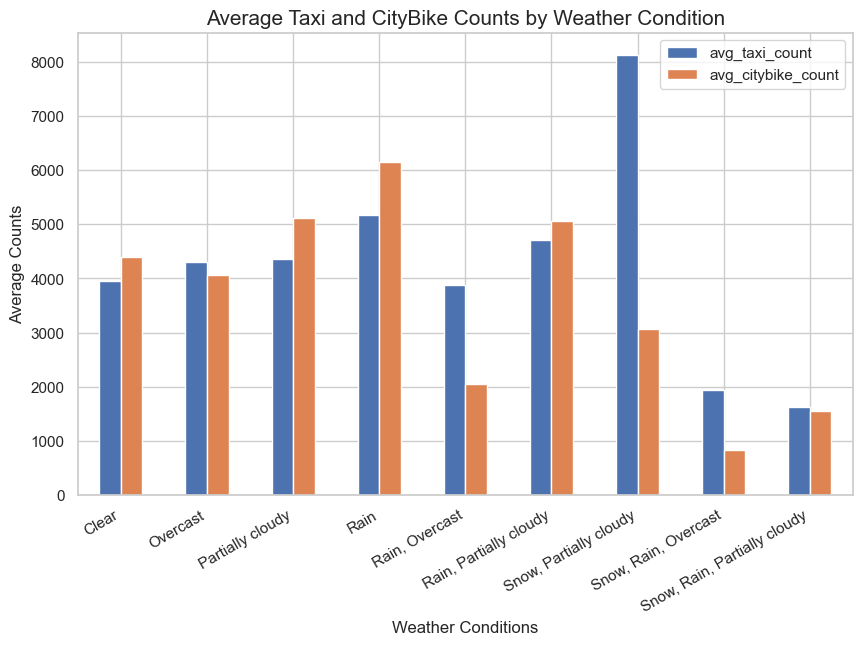

In [63]:
combined_df = combined_taxi_weather_9.join(combined_citybike_weather_9, on="conditions")
avg_df = combined_df.groupBy("conditions").agg(
    avg(col("taxi_count")).alias("avg_taxi_count"),
    avg(col("citybike_count")).alias("avg_citybike_count")
)
avg_df_pd = avg_df.toPandas()
avg_df_pd.set_index("conditions", inplace=True)
ax = avg_df_pd.plot(kind='bar', figsize=(10, 6))
plt.title('Average Taxi and CityBike Counts by Weather Condition',fontsize = 15)
plt.xlabel('Weather Conditions')
plt.ylabel('Average Counts')
plt.xticks(rotation=30, ha='right')
plt.show()

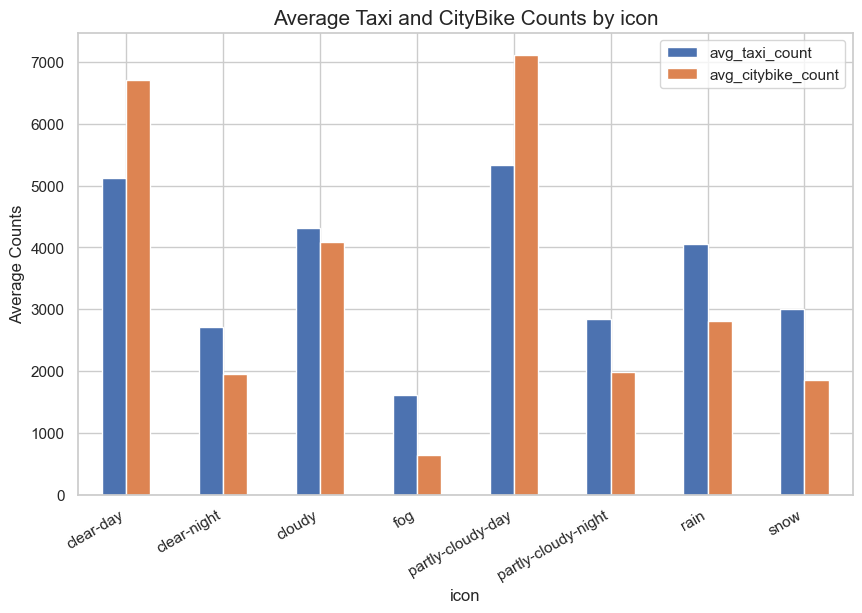

In [64]:
combined_df = combined_taxi_weather_9.join(combined_citybike_weather_9, on="icon")
avg_df = combined_df.groupBy("icon").agg(
    avg(col("taxi_count")).alias("avg_taxi_count"),
    avg(col("citybike_count")).alias("avg_citybike_count")
)
avg_df_pd = avg_df.toPandas()
avg_df_pd.set_index("icon", inplace=True)
ax = avg_df_pd.plot(kind='bar', figsize=(10, 6))
plt.title('Average Taxi and CityBike Counts by icon',fontsize = 15)
plt.xlabel('icon')
plt.ylabel('Average Counts')
plt.xticks(rotation=30, ha='right')
plt.show()

## The distribution of taxi_count and citiBike_count

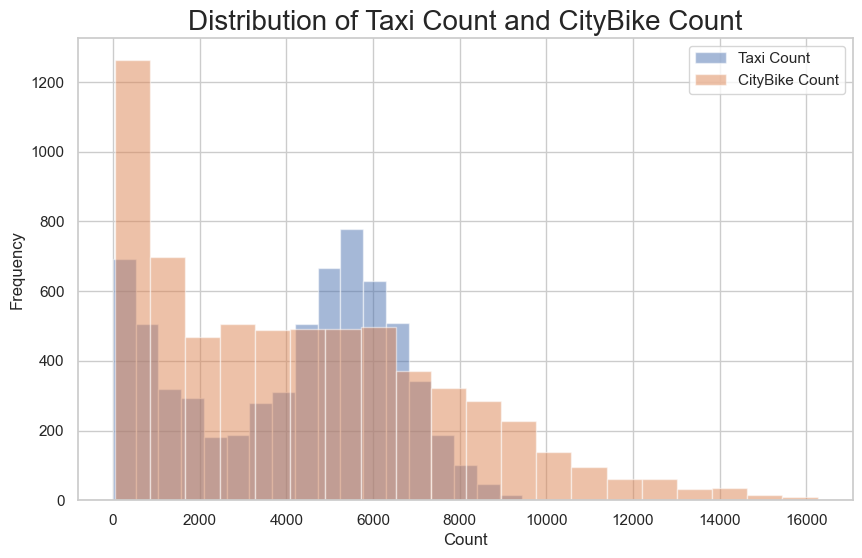

In [65]:
taxi_count_data = combined_taxi_weather_9.select("taxi_count").rdd.flatMap(lambda x: x).collect()
citybike_count_data = combined_citybike_weather_9.select("citybike_count").rdd.flatMap(lambda x: x).collect()
plt.figure(figsize=(10, 6))
plt.hist(taxi_count_data, bins=20, alpha=0.5, label='Taxi Count')
plt.hist(citybike_count_data, bins=20, alpha=0.5, label='CityBike Count')
plt.legend(loc='upper right')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.title('Distribution of Taxi Count and CityBike Count',fontsize = 20)
plt.show()

## Add new Attribute: Day of week

In [ ]:
combined_citybike_weather_9 = combined_citybike_weather_9.withColumn("day_of_week", date_format(combined_citybike_weather_9["datetime"], 'E')).drop('datetime')
combined_citybike_weather_2 = combined_citybike_weather_2.withColumn("day_of_week", date_format(combined_citybike_weather_2["datetime"], 'E')).drop('datetime')

In [ ]:
combined_taxi_weather_9 = combined_taxi_weather_9.withColumn("day_of_week", date_format(combined_taxi_weather_9["datetime"], 'E')).drop('datetime')
combined_taxi_weather_2 = combined_taxi_weather_2.withColumn("day_of_week", date_format(combined_taxi_weather_2["datetime"], 'E')).drop('datetime')

## Check the correlation between the categorical data and "count"

In [ ]:
# The function use to check the correlation by chi-square tesy
def chi_square_test(df, col1, col2):
    contingency_table = df.groupby(col1, col2).agg(spark_count("*").alias("count")).toPandas()
    contingency_table_pivot = contingency_table.pivot(index=col1, columns=col2, values='count').fillna(0)
    chi2_stat, p, dof, ex = chi2_contingency(contingency_table_pivot.values)
    return chi2_stat, p

In [ ]:
# check the categorical data of combined_taxi_weather
columns_to_test = ['hour','preciptype', 'conditions', 'icon', 'day_of_week','uvindex']
for col in columns_to_test:
    chi2_stat, p_value = chi_square_test(combined_taxi_weather_9, col, 'taxi_count')
    print(f"Chi-Square Test between {col} and 'taxi_count': chi2_stat={chi2_stat:.4f}, p-value={p_value:.4f}")

Chi-Square Test between hour and 'taxi_count': chi2_stat=104504.8920, p-value=0.0000


Chi-Square Test between preciptype and 'taxi_count': chi2_stat=14834.2568, p-value=0.0000


Chi-Square Test between conditions and 'taxi_count': chi2_stat=35164.9217, p-value=0.0000


Chi-Square Test between icon and 'taxi_count': chi2_stat=29834.4108, p-value=0.1935


Chi-Square Test between day_of_week and 'taxi_count': chi2_stat=26099.1542, p-value=0.0009


Chi-Square Test between uvindex and 'taxi_count': chi2_stat=41264.0823, p-value=0.9999


In [ ]:
# check the categorical data of combined_citybike_weather
columns_to_test = ['hour','preciptype', 'conditions', 'icon', 'day_of_week', 'uvindex']
for col in columns_to_test:
    chi2_stat, p_value = chi_square_test(combined_citybike_weather_9, col, 'citybike_count')
    print(f"Chi-Square Test between {col} and 'citybike_count': chi2_stat={chi2_stat:.4f}, p-value={p_value:.4f}")

Chi-Square Test between hour and 'citybike_count': chi2_stat=112155.3017, p-value=0.0000


Chi-Square Test between preciptype and 'citybike_count': chi2_stat=12370.6795, p-value=1.0000


Chi-Square Test between conditions and 'citybike_count': chi2_stat=37976.2471, p-value=0.1679


Chi-Square Test between icon and 'citybike_count': chi2_stat=32264.7810, p-value=0.9980


Chi-Square Test between day_of_week and 'citybike_count': chi2_stat=28491.3539, p-value=0.1915


Chi-Square Test between uvindex and 'citybike_count': chi2_stat=52947.1665, p-value=0.0000


## Check the correlation between the numerical data and the "count"

In [ ]:
# The function use to draw the heat plot
def plot_correlation_heatmap(data, numeric_columns, title='Correlation Matrix'):
    numeric_df = data.select(numeric_columns).toPandas()
    numeric_df = numeric_df.apply(pd.to_numeric, errors='coerce')
    numeric_df = numeric_df.dropna()
    if numeric_df.shape[1] < 2:
        raise ValueError("Not enough numeric columns to compute correlation matrix.")
    correlation_matrix = numeric_df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title(title)
    plt.show()


In [ ]:
# The colunm use to draw the heatmap for combined_taxi_wether
numeric_columns_taxi = ['temp', 'feelslike', 'dew', 'humidity', 'precip', 
            'windgust', 'windspeed', 'winddir', 
           'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 
           'solarenergy','severerisk','taxi_count']

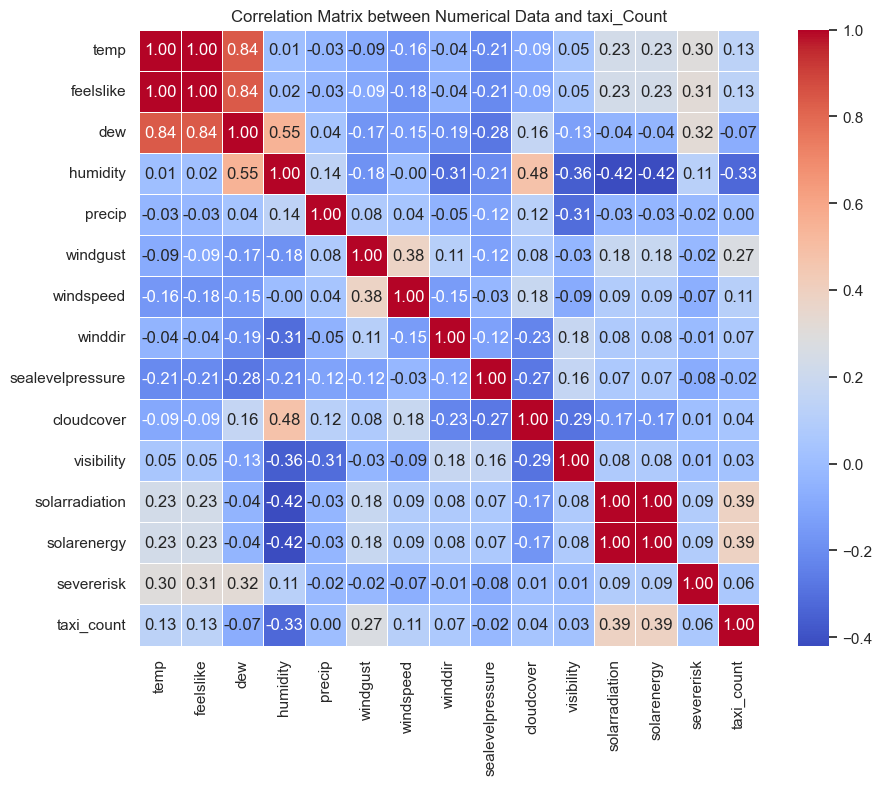

In [ ]:
# draw the heatmap
plot_correlation_heatmap(combined_taxi_weather_9, numeric_columns_taxi, title='Correlation Matrix between Numerical Data and taxi_Count')

In [ ]:
# The colunm use to draw the heatmap for combined_citybike_wether
numeric_columns_citybike = ['temp', 'feelslike', 'dew', 'humidity', 'precip', 
            'windgust', 'windspeed', 'winddir', 
           'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 
           'solarenergy','severerisk','citybike_count']

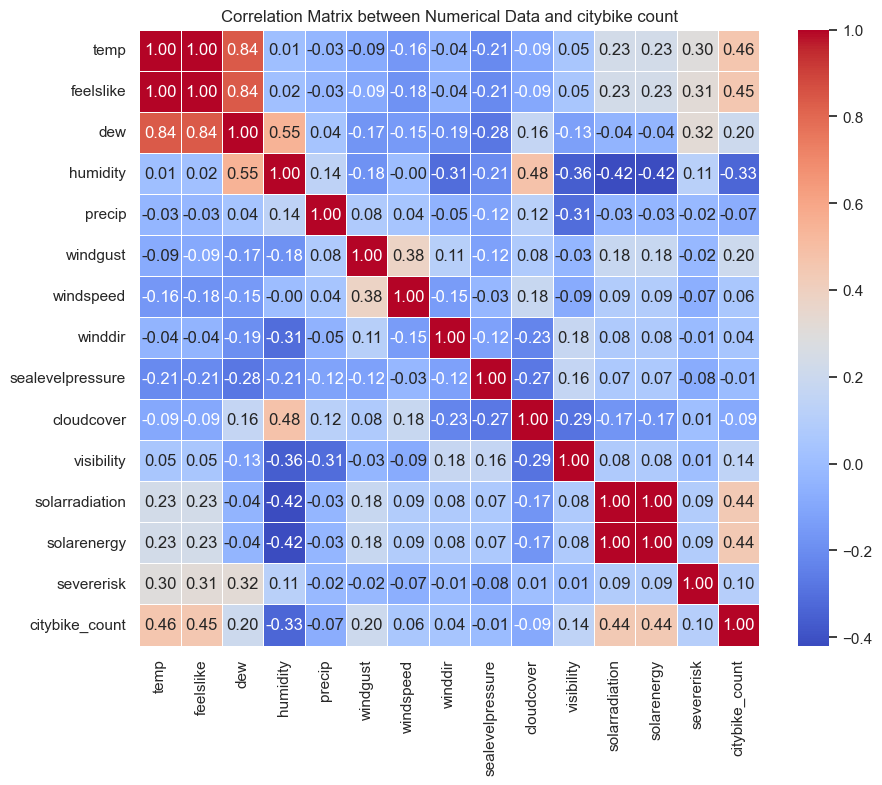

In [ ]:
# draw the heatmap
plot_correlation_heatmap(combined_citybike_weather_9, numeric_columns_citybike, title='Correlation Matrix between Numerical Data and citybike count')

## Drop the feature that we don’t need 

In [ ]:
# Attributes that are still retained
retained_attribute_taxi = ['hour','temp','humidity','preciptype','windgust','visibility','solarenergy','icon','day_of_week','taxi_count']
retained_attribute_citybike = ['hour','temp','dew','humidity','windgust','cloudcover','visibility','solarenergy','uvindex','severerisk','citybike_count']

In [ ]:
combined_taxi_weather_filtere_9 = combined_taxi_weather_9.select(*retained_attribute_taxi)
combined_citybike_weather_filtered_9 = combined_citybike_weather_9.select(*retained_attribute_citybike)
combined_taxi_weather_filtere_2 = combined_taxi_weather_2.select(*retained_attribute_taxi)
combined_citybike_weather_filtered_2 = combined_citybike_weather_2.select(*retained_attribute_citybike)

In [ ]:
print(combined_citybike_weather_filtered_9.count())
print(len(combined_citybike_weather_filtered_9.columns))

6551
11


In [ ]:
print(combined_citybike_weather_filtered_2.count())
print(len(combined_citybike_weather_filtered_2.columns))

1489
11


In [ ]:
print(combined_taxi_weather_filtere_9.count())
print(len(combined_taxi_weather_filtere_9.columns))

6551
10


In [ ]:
print(combined_taxi_weather_filtere_2.count())
print(len(combined_taxi_weather_filtere_2.columns))

1489
10


## Save data

In [ ]:
combined_taxi_weather_filtere_9.write.parquet("../data/after_EDA_data_Engineering/taxi-9")
combined_citybike_weather_filtered_9.write.parquet("../data/after_EDA_data_Engineering/citybike-9")
combined_taxi_weather_filtere_2.write.parquet("../data/after_EDA_data_Engineering/taxi-2")
combined_citybike_weather_filtered_2.write.parquet("../data/after_EDA_data_Engineering/citybike-2")

AnalysisException: [PATH_ALREADY_EXISTS] Path file:/Users/chumuhan/Desktop/project-1-individual-MuhanChu/data/after_EDA_data_Engineering/taxi-9 already exists. Set mode as "overwrite" to overwrite the existing path.